In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score , precision_score, recall_score

In [2]:
#check the gpu is available for training
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_dir = "E:/Nigga/ricediseasedetection/rice_datatset/Rice_Leaf_AUG"

In [4]:
image_size = 224 #299 or 331
batch_size = 32
channel = 3
n_classes = 9

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 11790 files belonging to 9 classes.


In [6]:
class_names = dataset.class_names
class_names

['Bacterial Leaf Blight',
 'Brown Spot',
 'Healthy Rice Leaf',
 'Leaf Blast',
 'Leaf scald',
 'Narrow Brown Leaf Spot',
 'Neck_Blast',
 'Rice Hispa',
 'Sheath Blight']

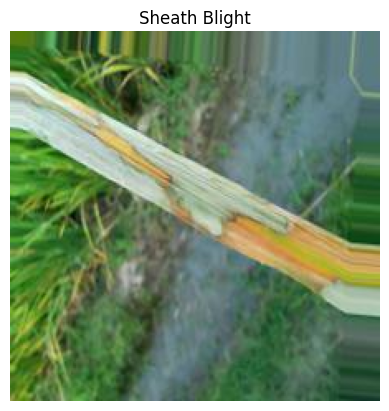

In [7]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [8]:
def split_dataset(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=123)
    train_size = int(train_split*dataset_size)
    val_size = int(val_split*dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset , val_dataset , test_dataset = split_dataset(dataset=dataset)

In [10]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
len(train_dataset)

295

In [12]:
len(test_dataset)

38

In [13]:
len(val_dataset)

36

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
])

In [15]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, channel)
)

In [17]:
base_model.trainable = False

In [18]:
model = models.Sequential([

    layers.Rescaling(1./255),

    base_model,

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

In [19]:
model.build(input_shape=(None,image_size,image_size,channel))

In [20]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [21]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
)
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [22]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/50
295/295 [==============================] - 127s 311ms/step - loss: 1.8673 - accuracy: 0.3216 - val_loss: 1.5112 - val_accuracy: 0.4965 - lr: 1.0000e-04
Epoch 2/50
295/295 [==============================] - 62s 209ms/step - loss: 1.5734 - accuracy: 0.4358 - val_loss: 1.3232 - val_accuracy: 0.5764 - lr: 1.0000e-04
Epoch 3/50
295/295 [==============================] - 62s 211ms/step - loss: 1.4438 - accuracy: 0.4855 - val_loss: 1.2135 - val_accuracy: 0.5851 - lr: 1.0000e-04
Epoch 4/50
295/295 [==============================] - 64s 215ms/step - loss: 1.3585 - accuracy: 0.5217 - val_loss: 1.1341 - val_accuracy: 0.6276 - lr: 1.0000e-04
Epoch 5/50
295/295 [==============================] - 63s 213ms/step - loss: 1.2973 - accuracy: 0.5409 - val_loss: 1.0845 - val_accuracy: 0.6094 - lr: 1.0000e-04
Epoch 6/50
295/295 [==============================] - 63s 214ms/step - loss: 1.2581 - accuracy: 0.5575 - val_loss: 0.9986 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 7/50
295/295 [=======

In [23]:
scores = model.evaluate(test_dataset)
print("Test Accuracy:", scores[1])

38/38 [==============================] - 39s 93ms/step - loss: 0.4969 - accuracy: 0.8257
Test Accuracy: 0.8256579041481018


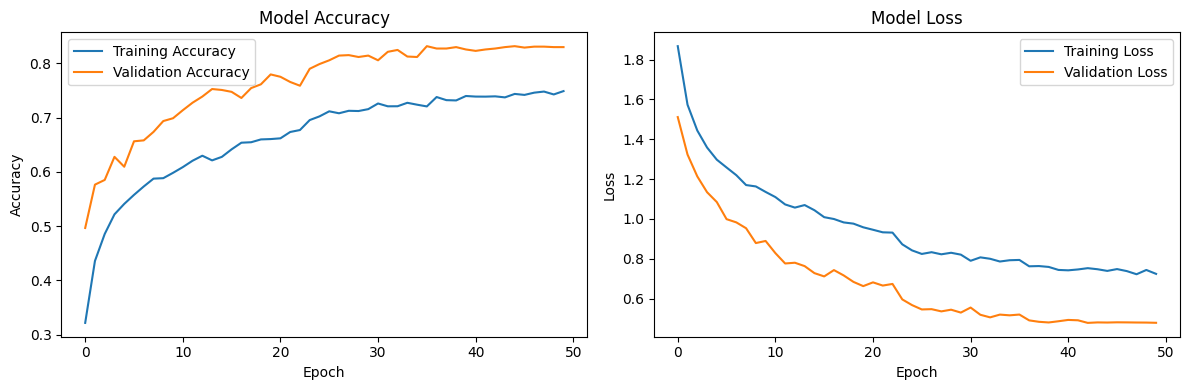

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


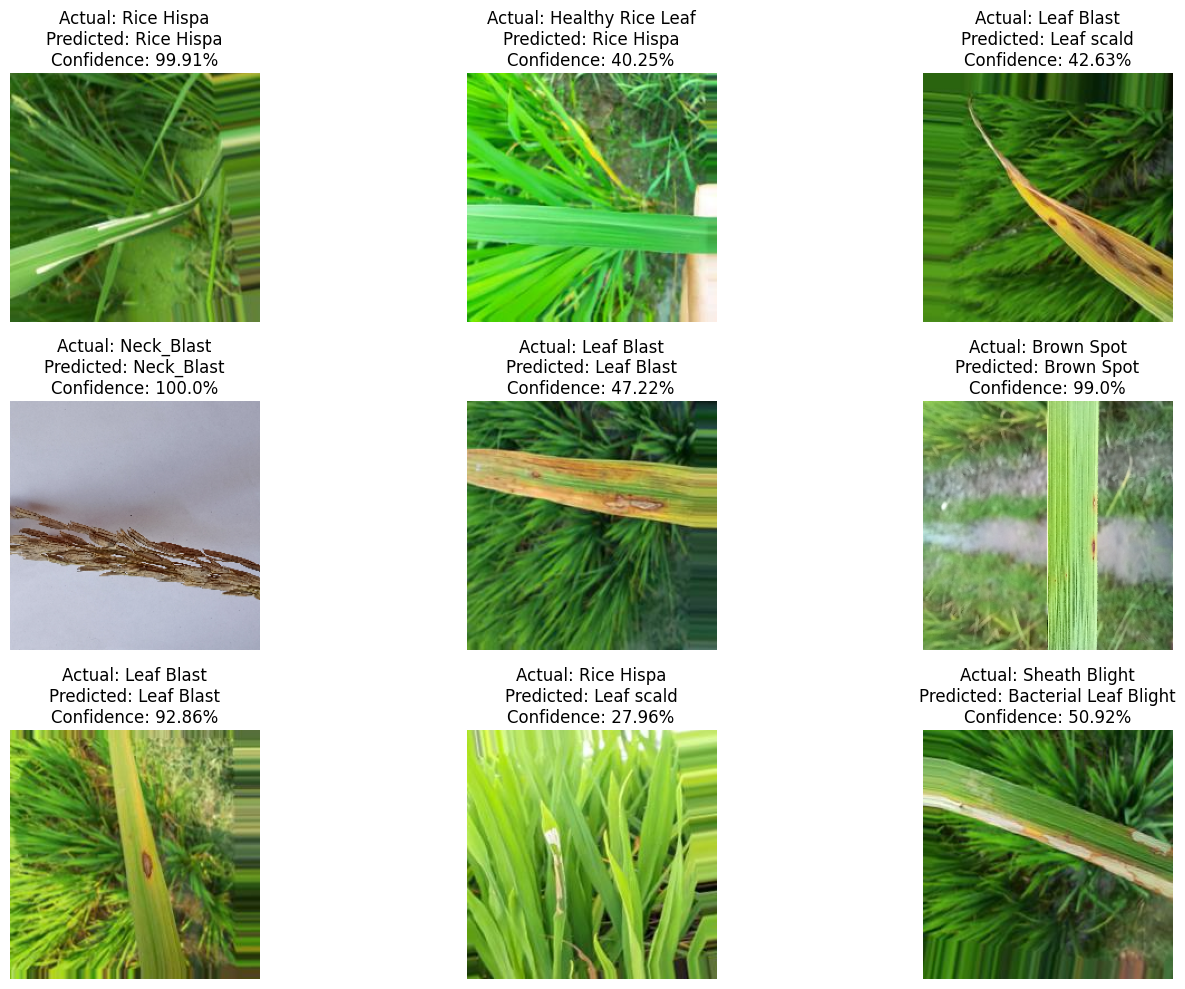

In [26]:
plt.figure(figsize=(15, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.tight_layout()

1/1 [==============================] - 0s 22ms/step


<Figure size 1000x800 with 0 Axes>

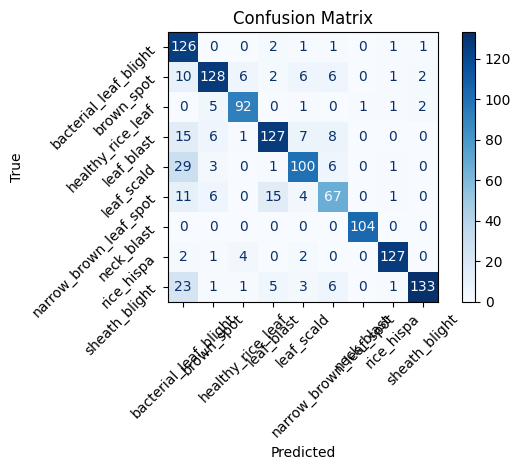

In [27]:

y_true = []
y_pred = []

# Collect predictions
for x, y in test_dataset:
    y_pred.extend(np.argmax(model.predict(x), axis=1))
    y_true.extend(y)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# Define class labels
display_labels = [
    'bacterial_leaf_blight',
    'brown_spot',
    'healthy_rice_leaf',
    'leaf_blast',
    'leaf_scald',
    'narrow_brown_leaf_spot',
    'neck_blast',
    'rice_hispa',
    'sheath_blight'
]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
# Calculate F1 scores for each class
f1_scores = f1_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# Print F1 scores
print("F1 Scores:")
print("bacterial_leaf_blight:", f1_scores[0])
print("brown_spot:", f1_scores[1])
print("healthy_rice_leaf:", f1_scores[2])
print("leaf_blast:", f1_scores[3])
print("leaf_scald:", f1_scores[4])
print("narrow_brown_leaf_spot:", f1_scores[5])
print("neck_blast:", f1_scores[6])
print("rice_hispa:", f1_scores[7])
print("sheath_blight:", f1_scores[8])

# Calculate macro-averaged F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro-averaged F1 Score:", macro_f1)


F1 Scores:
bacterial_leaf_blight: 0.7241379310344828
brown_spot: 0.8231511254019293
healthy_rice_leaf: 0.8932038834951457
leaf_blast: 0.8037974683544304
leaf_scald: 0.7575757575757576
narrow_brown_leaf_spot: 0.6767676767676768
neck_blast: 0.9952153110047847
rice_hispa: 0.9442379182156134
sheath_blight: 0.8553054662379421
Macro-averaged F1 Score: 0.8303769486764181


In [29]:
# Calculate precision and recall
precision = precision_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

recall = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# Print Precision
print("Precision:")
print("bacterial_leaf_blight:", precision[0])
print("brown_spot:", precision[1])
print("healthy_rice_leaf:", precision[2])
print("leaf_blast:", precision[3])
print("leaf_scald:", precision[4])
print("narrow_brown_leaf_spot:", precision[5])
print("neck_blast:", precision[6])
print("rice_hispa:", precision[7])
print("sheath_blight:", precision[8])

# Print Recall
print("\nRecall:")
print("bacterial_leaf_blight:", recall[0])
print("brown_spot:", recall[1])
print("healthy_rice_leaf:", recall[2])
print("leaf_blast:", recall[3])
print("leaf_scald:", recall[4])
print("narrow_brown_leaf_spot:", recall[5])
print("neck_blast:", recall[6])
print("rice_hispa:", recall[7])
print("sheath_blight:", recall[8])


Precision:
bacterial_leaf_blight: 0.5833333333333334
brown_spot: 0.8533333333333334
healthy_rice_leaf: 0.8846153846153846
leaf_blast: 0.8355263157894737
leaf_scald: 0.8064516129032258
narrow_brown_leaf_spot: 0.7127659574468085
neck_blast: 0.9904761904761905
rice_hispa: 0.9548872180451128
sheath_blight: 0.9637681159420289

Recall:
bacterial_leaf_blight: 0.9545454545454546
brown_spot: 0.7950310559006211
healthy_rice_leaf: 0.9019607843137255
leaf_blast: 0.774390243902439
leaf_scald: 0.7142857142857143
narrow_brown_leaf_spot: 0.6442307692307693
neck_blast: 1.0
rice_hispa: 0.9338235294117647
sheath_blight: 0.7687861271676301


In [30]:
model.save('ricedisease_vgg16.h5')

In [31]:
model.save('ricedisease_vgg16.keras')